### Sequential model (p245)

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))
model.build((None, 3))
model.weights
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

### Functional API model (p249)

In [15]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

# input
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)

priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(num_departments, activation="softmax", name="department")(
    features
)

model = keras.Model(inputs=[title, text_body, tags], outputs=[priority, department])

In [17]:
import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(
    optimizer="rmsprop",
    loss=["mean_squared_error", "categorical_crossentropy"],
    metrics=[["mean_absolute_error"], ["accuracy"]],
)
model.fit(
    [title_data, text_body_data, tags_data], [priority_data, department_data], epochs=1
)
model.evaluate(
    [title_data, text_body_data, tags_data], [priority_data, department_data]
)
priority_preds, department_preds = model.predict(
    [title_data, text_body_data, tags_data]
)



40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - department_accuracy: 0.2840 - loss: 35.6704 - priority_mean_absolute_error: 0.5107
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - department_accuracy: 0.1322 - loss: 37.7789 - priority_mean_absolute_error: 0.5028
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


### 7.3.1 사용자 정의 지표

In [18]:
### keras.metrics.Metric class 상속
import tensorflow as tf


class RootMeanSquaredError(keras.metrics.Metric):

    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32"
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.0)
        self.total_samples.assign(0)


model = get_mnist_model()
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", RootMeanSquaredError()],
)
model.fit(
    train_images, train_labels, epochs=3, validation_data=(val_images, val_labels)
)
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8647 - loss: 0.4490 - rmse: 0.4385 - val_accuracy: 0.9587 - val_loss: 0.1479 - val_rmse: 0.2538
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9523 - loss: 0.1621 - rmse: 0.2686 - val_accuracy: 0.9654 - val_loss: 0.1252 - val_rmse: 0.2336
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9640 - loss: 0.1302 - rmse: 0.2374 - val_accuracy: 0.9714 - val_loss: 0.1042 - val_rmse: 0.2090
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9700 - loss: 0.1059 - rmse: 0.2143


### 7.3.3 사용자 정의 콜백

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8663 - loss: 0.4456 - val_accuracy: 0.9576 - val_loss: 0.1493
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9513 - loss: 0.1675 - val_accuracy: 0.9679 - val_loss: 0.1205
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9622 - loss: 0.1308 - val_accuracy: 0.9726 - val_loss: 0.1083
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9669 - loss: 0.1168 - val_accuracy: 0.9757 - val_loss: 0.0988
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9708 - loss: 0.0985 - val_accuracy: 0.9766 - val_loss: 0.0928
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9762 - loss: 0.0892 - val_accuracy: 0.9776 - val_loss: 0.0912
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9767 - loss: 0.0818 - val_accuracy: 0.9756 - val_loss: 0.1009
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.9773 - loss:

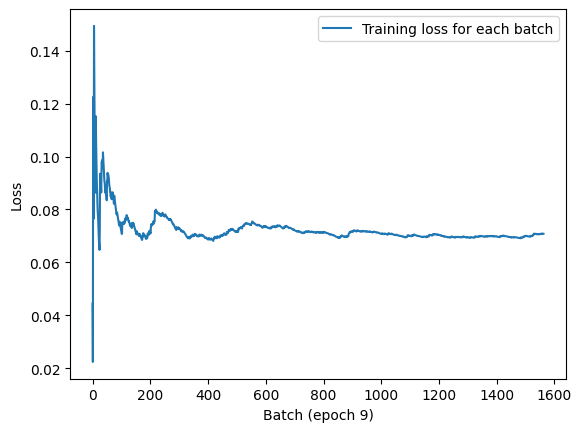

In [21]:
### keras.callbacks.Callback class 상속

from matplotlib import pyplot as plt


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(
            range(len(self.per_batch_losses)),
            self.per_batch_losses,
            label="Training loss for each batch",
        )
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []


model = get_mnist_model()
model.compile(
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    train_images,
    train_labels,
    epochs=10,
    callbacks=[LossHistory()],
    validation_data=(val_images, val_labels),
)

### (미션) sequential로는 구현이 불가능한 상황
- 입력 또는 출력이 여러개인 경우 sequential로 구현이 불가능하다.

### (미션) Functional로 구현하는 것 보다 sub classing으로 구현하는 것이 유리한 사례 
- DAG(directional Acyclic Graph) 로 나타낼 수 없는 경우. 즉, cyclic한 경우 같이 DAG를 만족하지 않을때

In [22]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

# MNIST 데이터셋 로드 및 전처리
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 데이터 정규화 및 형상 변경
train_images = train_images.reshape((60000, 28, 28, 1)).astype("float32") / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)).astype("float32") / 255.0

# CNN 모델 정의 (Conv2D와 MaxPooling2D를 각각 한 번씩만 사용)
model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

# 모델 컴파일
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# 모델 요약 출력
model.summary()

# 모델 훈련
history = model.fit(
    train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2
)

# 모델 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

# 손실과 정확도 시각화
history_dict = history.history

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

c:\Users\thilllon\git\aiffel\keras-deeplearning\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │       346,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,146 (1.32 MB)

 Trainable params: 347,146 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8757 - loss: 0.4372 - val_accuracy: 0.9765 - val_loss: 0.0864
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9792 - loss: 0.0708 - val_accuracy: 0.9795 - val_loss: 0.0715
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9857 - loss: 0.0463 - val_accuracy: 0.9835 - val_loss: 0.0572
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9900 - loss: 0.0325 - val_accuracy: 0.9833 - val_loss: 0.0568
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.9922 - loss: 0.0269 - val_accuracy: 0.9837 - val_loss: 0.0551
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9946 - loss: 0.0177 - val_accuracy: 0.9814 - val_loss: 0.0722
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9959 - loss: 0.0144 - val_accuracy: 0.9849 - val_loss: 0.0569
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9966 - loss: 0.0115 - val_accurac

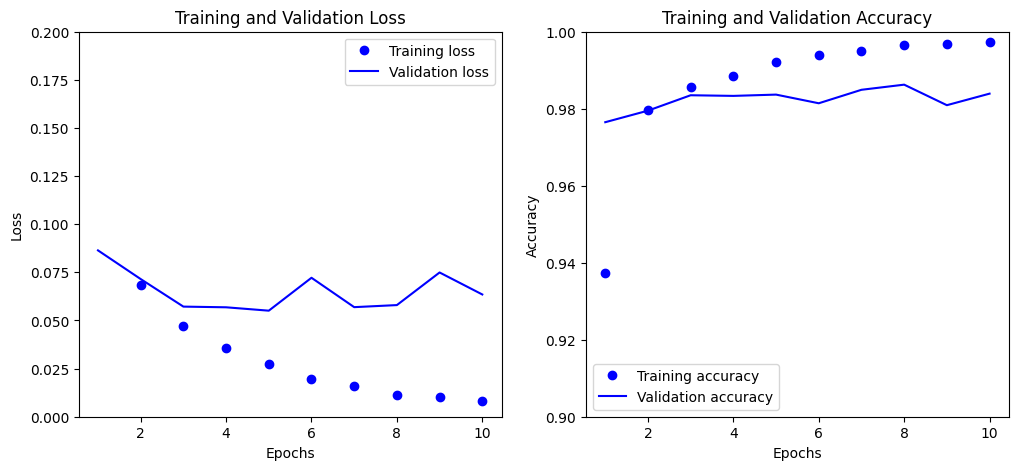

In [23]:
plt.figure(figsize=(12, 5))

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.2)
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
plt.legend()

plt.show()

In [24]:
# MNIST 데이터셋 로드 및 전처리
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 데이터 정규화 및 형상 변경
train_images = train_images.reshape((60000, 28, 28, 1)).astype("float32") / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)).astype("float32") / 255.0

# CNN 모델 정의 (Conv2D 두 번, MaxPooling2D 한 번 사용)
model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

# 모델 컴파일
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# 모델 요약 출력
model.summary()

# 모델 훈련
history = model.fit(
    train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2
)

# 모델 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

# 손실과 정확도 시각화
history_dict = history.history

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │       589,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,354 (2.32 MB)

 Trainable params: 609,354 (2.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - accuracy: 0.8951 - loss: 0.3451 - val_accuracy: 0.9820 - val_loss: 0.0627
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9866 - loss: 0.0436 - val_accuracy: 0.9868 - val_loss: 0.0474
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9928 - loss: 0.0235 - val_accuracy: 0.9878 - val_loss: 0.0424
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 0.9873 - val_loss: 0.0455
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9968 - loss: 0.0115 - val_accuracy: 0.9863 - val_loss: 0.0484
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.9965 - loss: 0.0107 - val_accuracy: 0.9870 - val_loss: 0.0547
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.9968 - loss: 0.0089 - val_accuracy: 0.9854 - val_loss: 0.0558
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9977 - loss: 0.0060 - 

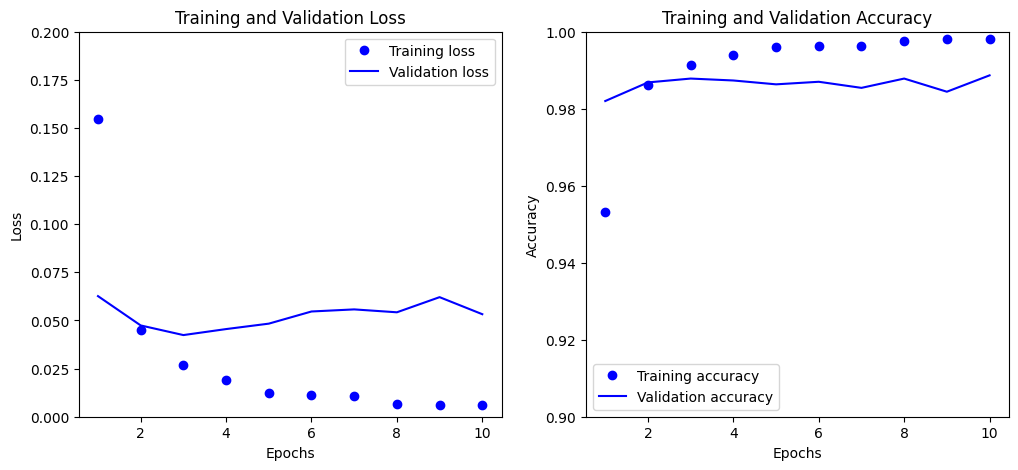

In [25]:
plt.figure(figsize=(12, 5))

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.2)
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
plt.legend()

plt.show()

In [26]:
# MNIST 데이터셋 로드 및 전처리
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# 데이터 정규화 및 형상 변경
train_images = train_images.reshape((60000, 28, 28, 1)).astype("float32") / 255.0
test_images = test_images.reshape((10000, 28, 28, 1)).astype("float32") / 255.0

# CNN 모델 정의 (Conv2D 두 번, MaxPooling2D 한 번 사용)
model = models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

# 모델 컴파일
model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# 모델 요약 출력
model.summary()

# 모델 훈련
history = model.fit(
    train_images, train_labels, epochs=10, batch_size=64, validation_split=0.2
)

# 모델 평가
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

# 손실과 정확도 시각화
history_dict = history.history

loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
accuracy = history_dict["accuracy"]
val_accuracy = history_dict["val_accuracy"]

epochs = range(1, len(loss) + 1)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 22, 22, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │       495,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 552,074 (2.11 MB)

 Trainable params: 552,074 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.8910 - loss: 0.3422 - val_accuracy: 0.9868 - val_loss: 0.0489
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.9886 - loss: 0.0403 - val_accuracy: 0.9868 - val_loss: 0.0493
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 49ms/step - accuracy: 0.9921 - loss: 0.0251 - val_accuracy: 0.9872 - val_loss: 0.0435
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 50ms/step - accuracy: 0.9947 - loss: 0.0168 - val_accuracy: 0.9827 - val_loss: 0.0658
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.9953 - loss: 0.0145 - val_accuracy: 0.9877 - val_loss: 0.0470
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.9971 - loss: 0.0088 - val_accuracy: 0.9897 - val_loss: 0.0424
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.9970 - loss: 0.0083 - val_accuracy: 0.9875 - val_loss: 0.0594
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 36s 48ms/step - accuracy: 0.9976 - loss: 0.0073 - 

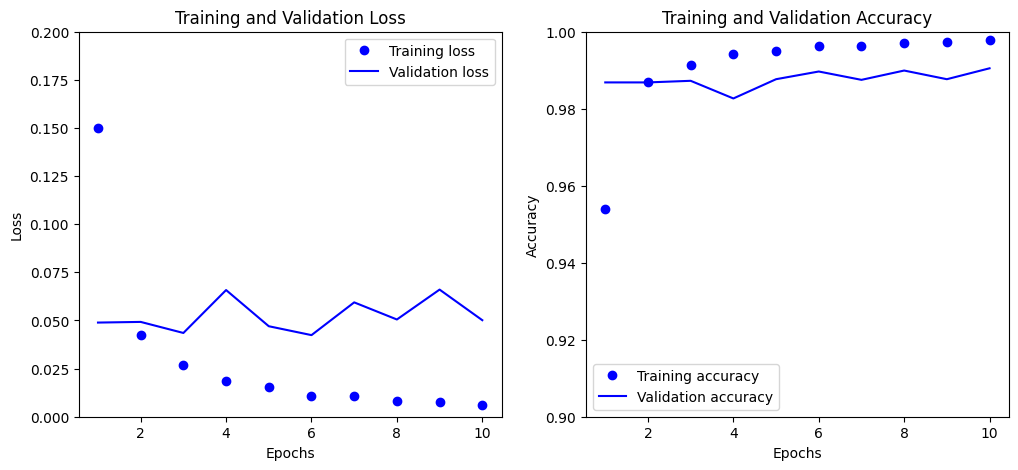

In [27]:
plt.figure(figsize=(12, 5))

# 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim(0, 0.2)
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1)
plt.legend()

plt.show()

### 결과분석
- `conv + maxpool` vs `conv + conv + maxpool` vs `conv + conv + conv + maxpool` 3가지로 비교실험하였다.
- 1번 케이스는 에폭5에서 과대적합이 발생, 2번에서는 에폭4에서 과대적합, 3번은 에폭 3에서 과대적합이 발생하였다.
- mnist data에서 layer 구성에 conv layer가 추가될 수록 과대적합이 빠르게 일어난다.
- 

### 회고
- 조별과제 인사이트
  - learning rate가 다르면 다르게 나온다.
  - mnist data에서 layer의 너비가 달라지면, 넓어질수록 정확해진다. 
  - mnist data에서 layer 구성에 conv layer가 추가될 수록 과대적합이 빠르게 일어난다.

- deeplearning playground 사이트가 동작하지 않아서 mnist 이용
- CNN을 모르는 상태에서 이미지 처리를 위해 Conv2D 등의 층을 써야해서 추가로 찾아봐야해서 시간이 많이 소요되었다. 